## Playing around with `torch_dreams`

This simple library was heavily inspired from: [Feature Visualization: How neural networks build up their understanding of images](https://distill.pub/2017/feature-visualization/)

`torch_dreams` aims to be something like [tensorflow/lucid](https://github.com/tensorflow/lucid) but in PyTorch in order to facilitate research in neural network interpretability

**Note**: This is by no means a PyTorch equivalent of lucid. But rather it is a bunch of useful tools which have similar intent to that of lucid.

In [221]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from torch_dreams.dreamer import dreamer
from torch_dreams.models.googlenet import GoogLeNet


In [222]:
model = GoogLeNet()
l = list(model.children())
good_layers = model.layer_names
good_layers

['inception3b', 'inception4c', 'inception4d', 'inception4e']

### Deep-dreams w.r.t conv layers 
Simple and straight, here we try to maximize the activations of the a conv layer as a whole. 

In [223]:
layer = model.inception4e.branch1.conv
layers_to_use = [layer]
layers_to_use

[Conv2d(528, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)]

In [224]:
dreamy_boi = dreamer(model)

dreamer init on:  cuda


In [225]:
out = dreamy_boi.deep_dream(
    image_path = "sample_small.jpg",
    layers = layers_to_use,
    octave_scale = 1.2,
    num_octaves = 12,
    iterations =40,
    lr = 0.9,
    custom_func =  None
)

100%|██████████| 13/13 [00:04<00:00,  2.81it/s]


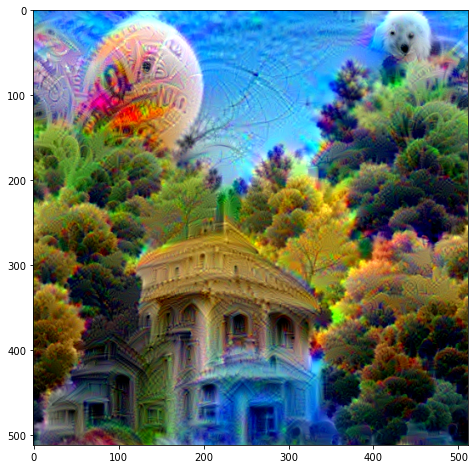

In [226]:
plt.rcParams['figure.figsize'] = 8, 8
plt.imshow(out)
plt.show()

### Deep-dreams w.r.t individual channels of conv layers 

This time, we aim to optimize the 0th channel of the conv layer. Notice how `my_custom_func` is tweaked to extract the activations of the 0th channel with `loss = layer_outputs[0][0].norm()`

In [270]:
def my_custom_func(layer_outputs):
    """
    this custom func would get applied to the list of layer outputs
    the layers whose outputs are given here are the ones you asked for in the layers arg
    """
    loss = layer_outputs[0][0].norm()  ## first channel from first layer 
    return loss

out = dreamy_boi.deep_dream(
    image_path = "sample_small.jpg",
    layers = layers_to_use,
    octave_scale = 1.2,
    num_octaves = 14,
    iterations =130,
    lr = 1.4,
    custom_func =  my_custom_func
)

100%|██████████| 15/15 [00:29<00:00,  1.94s/it]


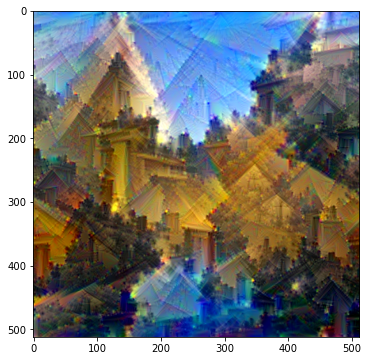

In [271]:
plt.rcParams['figure.figsize'] = 6,6

plt.imshow(out)
plt.show()

In [266]:
def my_custom_func(layer_outputs):

    loss = layer_outputs[0][125].norm()  ## 15 gives feathers 
    return loss

out = dreamy_boi.deep_dream(
    image_path = "sample_small.jpg",
    layers = layers_to_use,
    octave_scale = 1.2,
    num_octaves = 12,
    iterations =130,
    lr = 1.4,
    custom_func =  my_custom_func
)

100%|██████████| 13/13 [00:23<00:00,  1.79s/it]


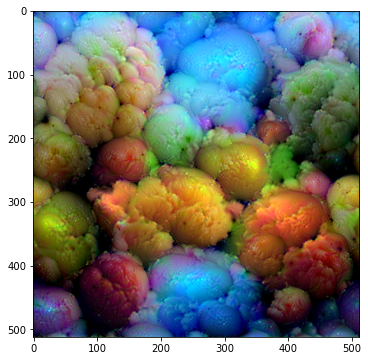

In [267]:
plt.rcParams['figure.figsize'] = 6,6

plt.imshow(out)
plt.show()

In [268]:
def my_custom_func(layer_outputs):

    loss = layer_outputs[0][125].norm() *0.5 + layer_outputs[0][0].norm()*0.5
    return loss

out = dreamy_boi.deep_dream(
    image_path = "sample_small.jpg",
    layers = layers_to_use,
    octave_scale = 1.2,
    num_octaves = 12,
    iterations =130,
    lr = 1.4,
    custom_func =  my_custom_func
)

100%|██████████| 13/13 [00:24<00:00,  1.88s/it]


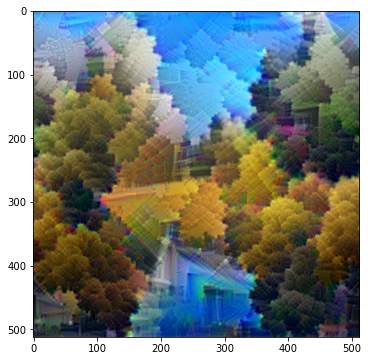

In [269]:
plt.rcParams['figure.figsize'] = 6,6

plt.imshow(out)
plt.show()